# Multi Output GPs in GPflow

### Multi Output Kernels class diagram
![new_multioutput_gp_kernels.png](attachment:new_multioutput_gp_kernels.png)




### Multi Output Features class diagram

![new_multioutput_gp_features.png](attachment:new_multioutput_gp_features.png)

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | M x P x M x P | M x P x N x P | fully_correlated_conditional    | This is the default. Will be very inefficient for certain kernels.                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant as we can achieve the same behaviour using the single output Kernel and InducingFeature classes. They are added for illustrative purposes.                           |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_latents_conditional | inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_latents_conditional | very similar as above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditinal                 | this is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf

In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

D = 1
M = 20
L = 2
P = 3
MAXITER = int(15e3)

In [3]:
pX = np.linspace(-6, 6, 100)[:, None]
def plot_model(m):
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

## Shared Independent MOK & Shared Independent Features (SLOW CODE)

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kernel = mk.SharedIndependentMok(gpf.kernels.RBF(D) + gpf.kernels.Linear(D), P)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.837586
  Number of iterations: 3371
  Number of functions evaluations: 3536


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


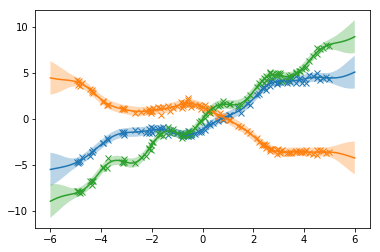

In [7]:
plot_model(m)

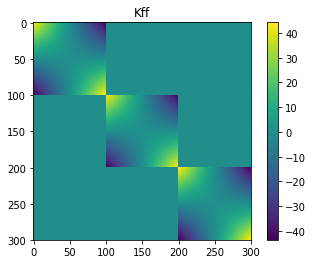

In [8]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, and the same kernel is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [9]:
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [10]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok
base conditional


In [11]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 68.837499
  Number of iterations: 3423
  Number of functions evaluations: 3628


Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok
base conditional


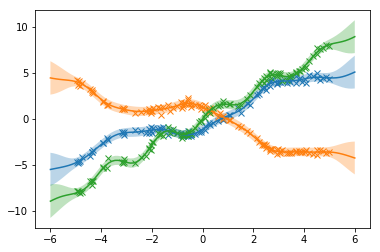

In [12]:
plot_model(m)

Again, same kernel used for each output dimension and the outputs are uncorrelated. In the `conditional`, however, we explicitly use the block-diagonal structure.

## Separate Independent MOK & Shared Independent Features (SLOW CODE)

In [13]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [14]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [15]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.926088
  Number of iterations: 4706
  Number of functions evaluations: 5025


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


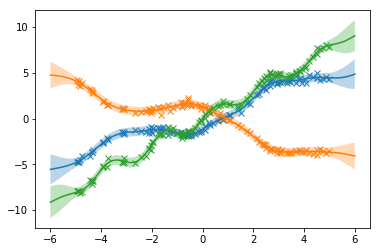

In [16]:
plot_model(m)

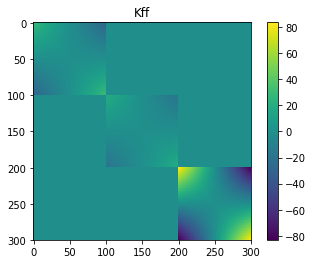

In [17]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
plt.imshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, *but a different kernel* is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Separate Independent MOK & Shared Independent Features

In [18]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [19]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


In [20]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 61.926214
  Number of iterations: 4283
  Number of functions evaluations: 4623


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


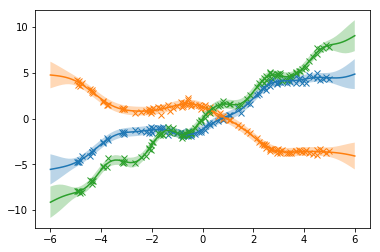

In [21]:
plot_model(m)

In [22]:
m.compute_log_likelihood()

-61.9262136516931

## Separate Independent Kernel & Separate Independent Features

In [23]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature_list = [gpf.features.InducingPoints(X[np.random.permutation(len(X))[:M],...].copy()) for _ in range(P)]
feature = mf.SeparateIndependentMof(feature_list)

In [24]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


In [25]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 85.178379
  Number of iterations: 1523
  Number of functions evaluations: 1632


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


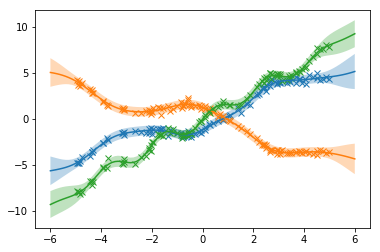

In [26]:
plot_model(m)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


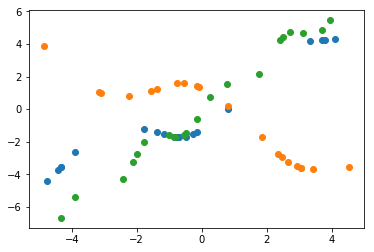

In [27]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitenede, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitenede[:, [i]], "o")

This plot shows that we use different inducing *inputs* in each output dimension.

# Mixed Kernel

## 1. Mixed Kernel & Correlated features (SLOW)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
In this scenario we ignore the fact that observations are produced by mixing uncorrelated latent GPs. We directly model the correlated observations. This means that we place our inducing outputs in the $f$ space and end up with the following (large) correlation matrices.

- $ K_{uu} = M \times P \times M  \times P $
- $ K_{uf} = M \times P \times N \times P $

We'll have to use `fully_correlated_conditional` or `base_conditional` depending on the `full_cov`/`full_cov_output` args.

In [28]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [29]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [30]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER);

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 44.973348
  Number of iterations: 9230
  Number of functions evaluations: 11080


Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


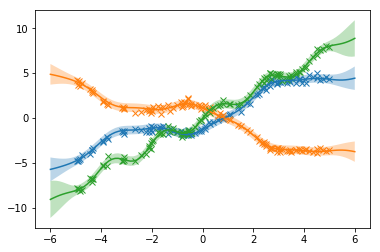

In [31]:
plot_model(m)

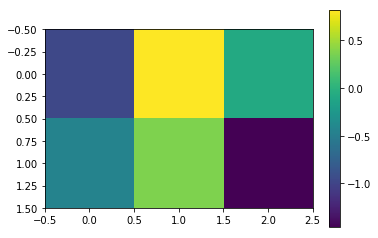

In [32]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 2. Mixed Kernel & Uncorrelated features (BETTER)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
In this scenario we assume that are inducing outputs live in the $g$ (i.e. $\mathbb{R}^L$) space.


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = M \times L \times N \times P $

We'll use `independent_latents_conditional`

In [33]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=Ptrue.T)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [34]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

independent_latents_conditional


In [35]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 26.504481
  Number of iterations: 7666
  Number of functions evaluations: 8190


independent_latents_conditional


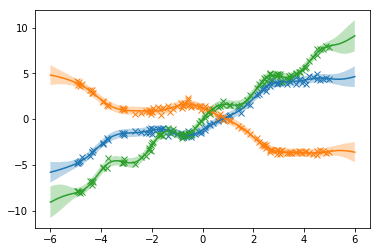

In [36]:
plot_model(m)

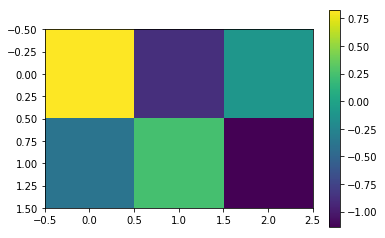

In [37]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 3. Mixed Kernel & Uncorrelated features (OPTIMAL)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

We'll use `base_conditional`

In [38]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [39]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


In [40]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 26.504683
  Number of iterations: 6955
  Number of functions evaluations: 7410


conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


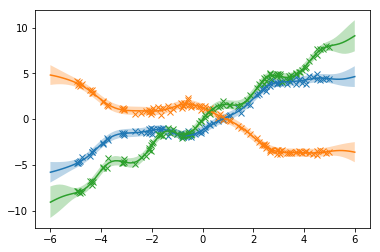

In [41]:
plot_model(m)